# Akbank Derin Öğrenme Bootcamp: Akciğer Röntgenlerinden Zatürre Tespiti 🫁
Bu notebook, Akbank Derin Öğrenme Bootcamp'i kapsamında geliştirilen bir derin öğrenme projesini içermektedir. Projenin temel amacı, göğüs röntgeni (X-ray) görüntülerinden zatürre (pneumonia) vakalarını yüksek bir doğrulukla tespit edebilen bir evrişimli sinir ağı (CNN) modeli geliştirmektir.

***Proje boyunca izlenen adımlar şunlardır:***

**Keşifsel Veri Analizi (EDA):** Veri setinin yapısı incelenmiş ve sınıflar arasındaki belirgin dengesizlik tespit edilmiştir.

**Temel Model (Baseline):** Sıfırdan bir CNN modeli kurularak bir referans başarı skoru elde edilmiştir.

**Gelişmiş Model (Transfer Learning):** ImageNet üzerinde eğitilmiş VGG16 mimarisi, Keras'ın Functional API'si kullanılarak projeye adapte edilmiş ve temel modelin başarısı önemli ölçüde artırılmıştır.

**Model Değerlendirme:** Modellerin performansı; doğruluk/kayıp grafikleri, karmaşıklık matrisi ve sınıflandırma raporu gibi metriklerle detaylıca analiz edilmiştir.

**Model Yorumlanabilirliği (Grad-CAM):** Gelişmiş modelin bir teşhis koyarken görüntünün hangi bölgelerine odaklandığı, Grad-CAM tekniği ile görselleştirilerek modelin "kara kutu" olmaktan çıkarılması hedeflenmiştir.

Bu çalışma, sadece yüksek bir doğruluk oranına ulaşmayı değil, aynı zamanda modelin kararlarının yorumlanabilirliğini de ön planda tutan kapsamlı bir derin öğrenme projesidir.

# Adım 1: Proje Kurulumu ve Keşifsel Veri Analizi (EDA) 
**Açıklama**:
Her derin öğrenme projesinin ilk ve en önemli adımı, üzerinde çalışacağımız veri setini tanımak ve çalışma ortamımızı hazırlamaktır. Bu bölümde, gerekli kütüphaneleri yükleyecek, veri setimizin dosya yollarını tanımlayacak ve keşifsel veri analizi (EDA) yapacağız. Yapacağımız analizler arasında, sınıfların dağılımını inceleyerek projemizin en önemli zorluklarından biri olan sınıf dengesizliğini ortaya çıkarmak ve her sınıftan örnek görüntüleri görselleştirerek verimiz hakkında sezgisel bir anlayış geliştirmek bulunmaktadır. Bu adım, projenin geri kalanı için sağlam bir temel oluşturacaktır.

## Adım 1.1: Kütüphaneleri Yükleme ve Yolları Tanımlama

**Açıklama**: İlk işimiz, projemizde kullanacağımız temel kütüphaneleri (pandas, os, matplotlib vb.) yüklemek ve biraz önce teyit ettiğimiz doğru klasör adını kullanarak tüm veri yollarını (eğitim, doğrulama, test) değişkenlere atamaktır. Bu, kodun geri kalanında bu yollara kolayca erişmemizi sağlar.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from PIL import Image

# Klasör adını kullanarak ana yolu tanımlayalım
DOGRU_KLASOR_ADI = 'chest-xray-pneumonia'

# Veri setinin alt klasörlerini kontrol edeliim.
base_path_guess1 = f'/kaggle/input/{DOGRU_KLASOR_ADI}/chest_xray/'
base_path_guess2 = f'/kaggle/input/{DOGRU_KLASOR_ADI}/'

if os.path.exists(os.path.join(base_path_guess1, 'train')):
    base_path = base_path_guess1
else:
    base_path = base_path_guess2

# Eğitim, doğrulama ve test klasörlerinin yollarını oluşturalım
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

print("Dosya yolları başarıyla tanımlandı:")
print(f"Ana yol: {base_path}")
print(f"Eğitim seti yolu: {train_path}")
print(f"Doğrulama seti yolu: {val_path}")
print(f"Test seti yolu: {test_path}")

2025-09-26 20:03:19.137574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758916999.523769      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758916999.622262      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dosya yolları başarıyla tanımlandı:
Ana yol: /kaggle/input/chest-xray-pneumonia/chest_xray/
Eğitim seti yolu: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Doğrulama seti yolu: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test seti yolu: /kaggle/input/chest-xray-pneumonia/chest_xray/test


## Adım 1.2: Sınıf Klasörlerini Keşfetme

**Açıklama**: Artık eğitim verilerimizin bulunduğu *train_path* yolunu bildiğimize göre, bu klasörün içinde hangi alt klasörlerin olduğunu listeleyerek projemizdeki sınıfların isimlerini öğrenebiliriz. Bu veri setinde, klasör isimleri doğrudan sınıf etiketleridir.

In [2]:
# Eğitim klasörünün içindeki alt klasörleri (yani sınıfları) listeleyelim
classes = os.listdir(train_path)

print(f"Eğitim setindeki sınıflar: {classes}")

Eğitim setindeki sınıflar: ['PNEUMONIA', 'NORMAL']


## Adım 1.3: Her Sınıftaki Görüntü Sayısını Sayma

**Açıklama**: Şimdi projemizin en önemli analizlerinden birini yapacağız. *train*, *val* ve *test* klasörlerinin her birinin içindeki *NORMAL* ve *PNEUMONIA* klasörlerini tek tek gezip, içlerinde kaçar tane görüntü dosyası olduğunu saydıracağız. Bu, bize veri setimizdeki sınıf dengesizliği hakkında net, sayısal bir sonuç verecek.

In [3]:
# Her bir setteki görüntü sayılarını tutmak için bir sözlük oluşturalım
data_counts = {'train': {}, 'val': {}, 'test': {}}
sets = {'train': train_path, 'val': val_path, 'test': test_path}

# Her bir seti (train/val/test) ve içindeki sınıfları döngüyle gezelim
for set_name, set_path in sets.items():
    for class_name in classes:
        # Sınıfa ait klasörün tam yolunu oluşturalım
        class_path = os.path.join(set_path, class_name)
        
        # O sınıfa ait dosya sayısını sayıp sözlüğe ekleyelim
        # .DS_Store gibi gizli dosyaları saymamak için bir kontrol ekleyebiliriz
        count = len([file for file in os.listdir(class_path) if not file.startswith('.')])
        data_counts[set_name][class_name] = count

# Sonuçları daha okunaklı bir DataFrame'e çevirip ekrana basalım
df_counts = pd.DataFrame(data_counts)
print("Her setteki sınıf dağılımı:")
print(df_counts)

Her setteki sınıf dağılımı:
           train  val  test
PNEUMONIA   3875    8   390
NORMAL      1341    8   234


## Adım 1.4: Sınıf Dağılımını Görselleştirme

**Açıklama**: Bir önceki adımda hesapladığımız sayıları kullanarak bir çubuk grafik (bar plot) çizeceğiz. Bu grafik, *train*, *val* ve *test* setlerindeki *NORMAL* ve *PNEUMONIA* sınıfları arasındaki dengesizliği bir bakışta anlamamızı sağlayacak. Özellikle eğitim setindeki büyük fark, modelimizi eğitirken neden dikkatli olmamız gerektiğini bize gösterecek.

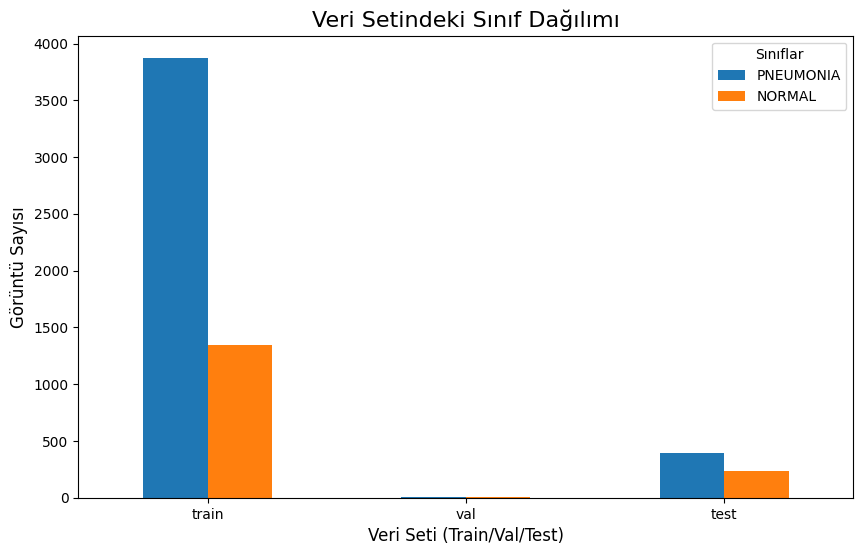

In [4]:
# Bir önceki adımda oluşturduğumuz df_counts DataFrame'ini kullanarak grafiği çizelim
# .T (transpose) ile satır ve sütunların yerini değiştirerek daha okunaklı bir grafik elde ederiz
df_counts.T.plot(kind='bar', figsize=(10, 6), stacked=False)

plt.title('Veri Setindeki Sınıf Dağılımı', fontsize=16)
plt.xlabel('Veri Seti (Train/Val/Test)', fontsize=12)
plt.ylabel('Görüntü Sayısı', fontsize=12)
plt.xticks(rotation=0) # x eksenindeki etiketleri düz göster
plt.legend(title='Sınıflar')
plt.show()

## Adım 1.5: Görüntüleri Gözle İnceleme

**Açıklama**: Grafikler ve sayılar bize veri setinin dağılımını gösterdi. Şimdi de verinin kendisini, yani röntgen görüntülerini inceleyelim. *NORMAL* ve *PNEUMONIA* olarak etiketlenmiş görüntülerden birkaç örnek görmek, modelimizin ne tür görsel desenleri öğrenmesi gerektiği konusunda bize sezgisel bir fikir verecektir.

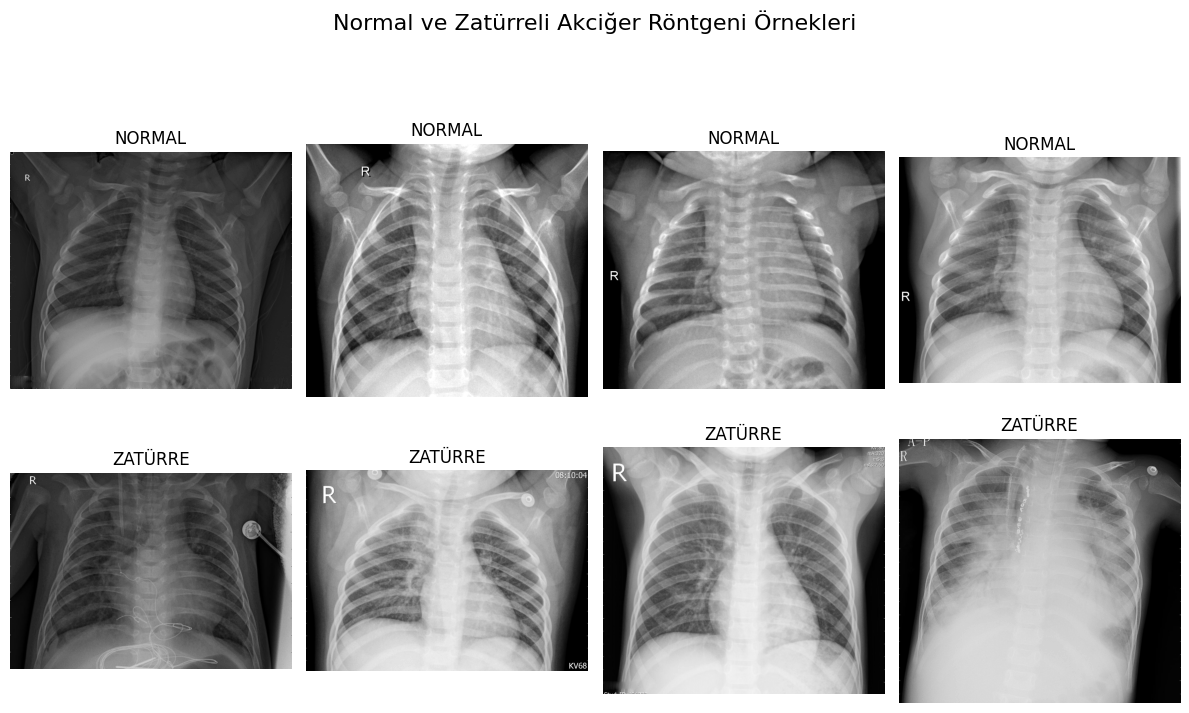

In [5]:
plt.figure(figsize=(12, 8))

# Normal sınıfından 4 örnek görüntü alalım
normal_path = os.path.join(train_path, 'NORMAL')
normal_images = os.listdir(normal_path)[:4] 
for i, img_name in enumerate(normal_images):
    img = Image.open(os.path.join(normal_path, img_name))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('NORMAL')
    plt.axis('off')

# Pneumonia sınıfından 4 örnek görüntü alalım
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
pneumonia_images = os.listdir(pneumonia_path)[:4]
for i, img_name in enumerate(pneumonia_images):
    img = Image.open(os.path.join(pneumonia_path, img_name))
    plt.subplot(2, 4, i + 5)
    plt.imshow(img, cmap='gray')
    plt.title('ZATÜRRE')
    plt.axis('off')

plt.suptitle('Normal ve Zatürreli Akciğer Röntgeni Örnekleri', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Adım 2: Veri Ön İşleme ve Artırma Pipeline'ı

**Hedef**: Görüntülerimizi derin öğrenme modelinin "anlayabileceği" standart bir formata getirmek ve modelimizin daha iyi genelleme yapabilmesi için Veri Artırma (Data Augmentation)  tekniklerini uygulamak.

## Adım 2.1: Veri Artırma Stratejisini ve Parametreleri Belirleme

**Açıklama**:
Modelimizi eğitmeden önce tüm görüntülerin aynı boyutta ve aynı piksel değer aralığında (genellikle 0-1 arası) olması gerekir. Ayrıca, modelimizin aynı görüntünün hafifçe değiştirilmiş versiyonlarını da görerek daha sağlam ve ezberlemeye daha az yatkın olmasını sağlamak için veri artırma  uygularız.

**Eğitim Seti İçin (train_datagen)**: Bu sete çeşitli artırma teknikleri uygulayacağız. Örneğin, görüntüyü hafifçe döndürme (Rotation) , yakınlaştırma (Zoom), kaydırma gibi. Böylece modelimiz her epoch'ta aynı görüntünün biraz farklı bir versiyonunu görerek daha iyi öğrenir.


**Doğrulama ve Test Setleri İçin (test_val_datagen)**: Bu setlere artırma uygulamayız. Çünkü modelin performansını, orijinal, değiştirilmemiş görüntüler üzerinde ne kadar iyi olduğunu görerek ölçmek isteriz. Bu setler için yapacağımız tek işlem, piksel değerlerini 0-1 arasına getirmek (normalizasyon) olacaktır.

In [6]:
# TensorFlow ve Keras'tan gerekli modülleri import edelim
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings 

# Projemiz için temel parametreleri tanımlayalım
IMAGE_SIZE = (224, 224) # Tüm resimleri 150x150 piksele yeniden boyutlandıracağız
BATCH_SIZE = 32 # Modelimize her seferinde 32 resimlik gruplar halinde veri vereceğiz

# Eğitim seti için veri artırma ve normalizasyon "reçetesi"
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Piksel değerlerini 0-1 arasına ölçekle (normalizasyon)
    rotation_range=15,       # Görüntüleri rastgele 15 dereceye kadar döndür 
    width_shift_range=0.1,   # Genişlikte %10'a kadar rastgele kaydır
    height_shift_range=0.1,  # Yükseklikte %10'a kadar rastgele kaydır
    shear_range=0.1,         # Görüntüyü hafifçe eğ/bük
    zoom_range=0.1,          # %10'a kadar rastgele yakınlaştır 
    horizontal_flip=True,    # Görüntüyü rastgele yatay olarak çevir [cite: 24]
    fill_mode='nearest'      # Oluşan boşlukları en yakın pikselle doldur
)

# Doğrulama ve Test setleri için SADECE normalizasyon "reçetesi"
test_val_datagen = ImageDataGenerator(rescale=1./255)
warnings.filterwarnings('ignore')

print("ImageDataGenerator'lar başarıyla oluşturuldu.")

ImageDataGenerator'lar başarıyla oluşturuldu.


## Adım 2.2: Veri Jeneratörlerini Oluşturma

**Açıklama**: Bir önceki adımda veri artırma için tariflerimizi (ImageDataGenerator objelerini) oluşturmuştuk. Şimdi bu tarifleri kullanarak klasörlerimizdeki görüntülerden veri okuyacak ve modelimizi besleyecek olan asıl jeneratorleri oluşturacağız.

Bunun için *flow_from_directory* metodunu kullanıyoruz. Bu metod, klasör yapısına (*train/NORMAL*, *train/PNEUMONIA*) bakarak sınıfları otomatik olarak anlar ve görüntüleri gruplar halinde (batch) hazırlayarak model eğitimini çok verimli hale getirir.

In [7]:
# Eğitim jeneratörünü oluşturalım
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', # İki sınıfımız olduğu için 'binary'
    color_mode='grayscale', # Görüntülerimiz gri tonlamalı olduğu için
    shuffle=True # Eğitim verisini karıştır
)

# Doğrulama jeneratörünü oluşturalım
validation_generator = test_val_datagen.flow_from_directory(
    directory=val_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False # Doğrulama verisini karıştırmıyoruz
)

# Test jeneratörünü oluşturalım
test_generator = test_val_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False # Test verisini de karıştırmıyoruz
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Adım 2.3: Artırılmış Görüntüleri Görselleştirme

**Açıklama**: Veri artırma için bir "tarif" oluşturduk ama bu tarifin ortaya nasıl görüntüler çıkardığını görmek çok önemlidir. Bu adımda, eğitim jeneratörümüzden (*train_generator*) bir grup (*batch*) artırılmış görüntü alıp görselleştireceğiz. Bu, uyguladığımız döndürme, yakınlaştırma gibi işlemlerin makul göründüğünden ve modelimizi eğitmek için çeşitli ve anlamlı örnekler ürettiğimizden emin olmamızı sağlar.

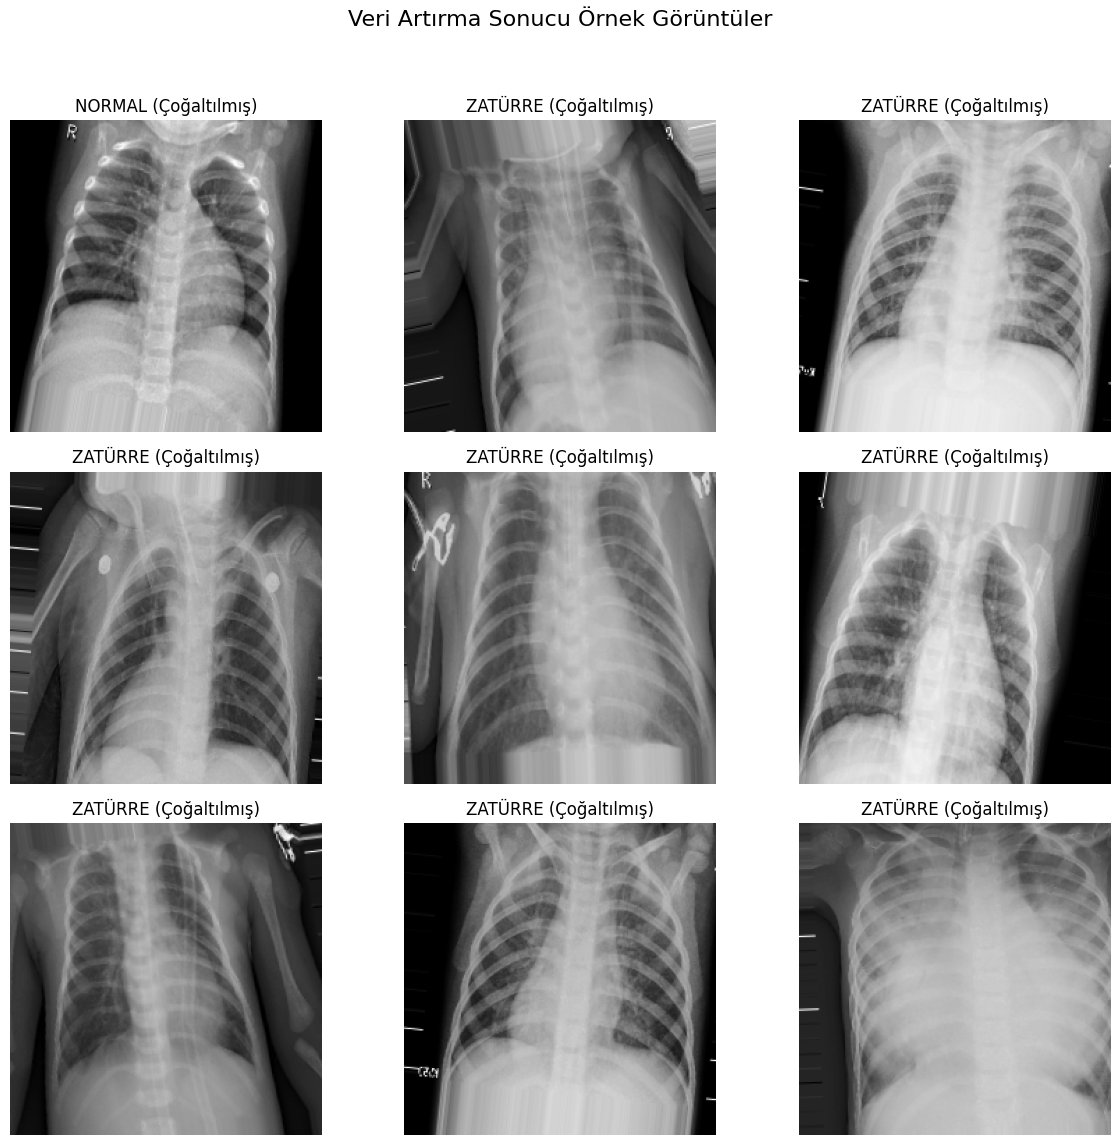

In [8]:
# Eğitim jeneratöründen bir batch'lik görüntü ve etiket alalım
sample_images, sample_labels = next(train_generator)

# Bu batch'teki ilk 9 görüntüyü görselleştirelim
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Görüntüler (150, 150, 1) boyutunda olduğu için son boyutu sıkıştırmamız gerekiyor
    plt.imshow(np.squeeze(sample_images[i]), cmap='gray')
    
    # Etiketler 0 (NORMAL) ve 1 (PNEUMONIA) olarak gelir
    if sample_labels[i] == 0:
        plt.title('NORMAL (Çoğaltılmış)')
    else:
        plt.title('ZATÜRRE (Çoğaltılmış)')
    
    plt.axis('off')

plt.suptitle('Veri Artırma Sonucu Örnek Görüntüler', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Adım 3: Baseline (Temel) CNN Modeli Oluşturma

**Açıklama**:
Bu adımda, bootcamp gereksinimlerini karşılayan, sıfırdan basit bir Evrişimli Sinir Ağı (Convolutional Neural Network - CNN) modeli oluşturacağız. Bu modele "Baseline Model" (Temel Model) diyoruz çünkü amacı en yüksek başarıyı elde etmek değil, daha sonra kuracağımız gelişmiş modele karşı bir referans noktası veya taban çizgisi oluşturmaktır.

Modelimiz şu temel katmanlardan oluşacak:

**Conv2D (Evrişim Katmanı)**: Görüntülerdeki kenarlar, dokular gibi temel özellikleri tespit etmek için kullanılır.

**MaxPooling2D (Ortaklama Katmanı)**: Tespit edilen özelliklerin konumuna karşı modeli daha duyarsız hale getirir ve hesaplama yükünü azaltır.

**Flatten**: İki boyutlu özellik haritalarını, sınıflandırma katmanına girebilmesi için tek boyutlu bir vektöre düzleştirir.

**Dropout**: Modelin ezber yapmasını (overfitting) önlemek için kullanılan bir regülarizasyon tekniğidir.

**Dense (Yoğun Katman)**: Tespit edilen özelliklere dayanarak nihai sınıflandırmayı yapan katmandır.


## Adım 3.1: Model Mimarisi ve Derleme

**Açıklama**:
İlk olarak Keras Sequential API'sini kullanarak model mimarimizi katman katman oluşturacağız. Ardından, modeli compile metodu ile eğitime hazırlayacağız. Bu aşamada modelimize hangi optimizer'ı, hangi kayıp fonksiyonunu ve hangi başarı metriklerini kullanacağını söyleriz.

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import warnings

# warnings.filterwarnings('ignore') satırını genellikle en başa koymak iyi bir pratiktir
warnings.filterwarnings('ignore')

# Modelimizi oluşturalım
model = Sequential([
    # Girdi boyutu burada, input katmanında belirtilir
    Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    
    # 1. Konvolüsyon Bloğu
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # 2. Konvolüsyon Bloğu
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # 3. Konvolüsyon Bloğu
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Sınıflandırma katmanlarına hazırlık
    Flatten(),
    
    # Yoğun (Dense) katmanlar
    Dense(512, activation='relu'),
    Dropout(0.5), # Overfitting'i önlemek için
    
    # Çıkış katmanı
    Dense(1, activation='sigmoid')
])

# Modeli derleyelim
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Modelin mimarisini ve parametre sayısını görelim
model.summary()

I0000 00:00:1758917025.823412      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758917025.824122      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,033 (169.36 MB)

 Trainable params: 44,396,033 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

## Adım 3.2: Sınıf Dengesizliği İçin Ağırlık Hesaplama

**Açıklama**:
Eğitim setimizde Zatürre sınıfından çok daha fazla görüntü olduğunu hatırlayalım. Eğer modeli doğrudan bu veriyle eğitirsek, modelimiz azınlıkta olan Normal sınıfını öğrenmekte zorlanabilir ve sürekli olarak çoğunluk sınıfını tahmin etmeye yönelebilir.

Bunu önlemek için sınıf ağırlıkları (class weights) kullanacağız. Bu teknikle, modelin kayıp fonksiyonunu (*loss* *function*) hesaplarken, azınlıkta olan Normal sınıfından yaptığı hatalara daha fazla "ceza" (daha yüksek ağırlık) verilir. Bu, modeli her iki sınıfı da eşit derecede iyi öğrenmeye teşvik eder.

In [10]:
# Adım 1.3'te hesapladığımız df_counts'tan eğitim verisi sayılarını alalım
normal_count = df_counts.loc['NORMAL', 'train']
pneumonia_count = df_counts.loc['PNEUMONIA', 'train']
total_count = normal_count + pneumonia_count

# Sınıf ağırlıklarını hesaplayalım
weight_for_0 = (1 / normal_count) * (total_count / 2.0)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Normal sınıfı için ağırlık: {class_weight[0]:.2f}")
print(f"Zatürre sınıfı için ağırlık: {class_weight[1]:.2f}")

Normal sınıfı için ağırlık: 1.94
Zatürre sınıfı için ağırlık: 0.67


## Adım 3.3: Modeli Eğitme

**Açıklama**:
Artık her şey hazır. *model.fit()* fonksiyonu ile eğitim sürecini başlatacağız. Bu fonksiyon, *train_generator*'dan aldığı veri gruplarıyla (batch) modelin ağırlıklarını tekrar tekrar günceller. Her epoch (tur), modelin tüm eğitim setini bir kez gördüğü anlamına gelir. Eğitim sırasında, modelin performansını *validation_generator* üzerinde de izleyerek ezber yapıp yapmadığını kontrol ederiz. Bir önceki adımda hesapladığımız *class_weight*'i de burada kullanacağız.

In [11]:
import warnings
# Modeli eğitelim
# Baseline model için 10 epoch yeterli bir başlangıçtır
EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weight
)

warnings.filterwarnings('ignore')

print("\nModel eğitimi tamamlandı!")

Epoch 1/10


I0000 00:00:1758917031.348763     188 service.cc:148] XLA service 0x794fe00046c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758917031.350458     188 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758917031.350479     188 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758917031.784015     188 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5625 - loss: 0.9459 

I0000 00:00:1758917037.109812     188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 482ms/step - accuracy: 0.7181 - loss: 0.5735 - val_accuracy: 0.7500 - val_loss: 0.4886
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 309ms/step - accuracy: 0.8693 - loss: 0.3093 - val_accuracy: 0.9375 - val_loss: 0.3446
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 302ms/step - accuracy: 0.8817 - loss: 0.2760 - val_accuracy: 0.9375 - val_loss: 0.3500
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 303ms/step - accuracy: 0.9130 - loss: 0.2194 - val_accuracy: 0.7500 - val_loss: 0.5735
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - accuracy: 0.9029 - loss: 0.2284 - val_accuracy: 0.9375 - val_loss: 0.2498
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 305ms/step - accuracy: 0.9072 - loss: 0.2191 - val_accuracy: 0.9375 - val_loss: 0.1837
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - accuracy: 0.9258 - loss: 0.1877 - val_accuracy: 0.8125 - val_loss: 0.2615
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 305ms/step - accuracy: 0.9218 - loss: 0.1957 - val

# Adım 4: Modelin Performansını Değerlendirme ve Görselleştirme

Modeli eğittik, şimdi de ne kadar başarılı olduğunu ve eğitim sürecinin nasıl ilerlediğini detaylıca inceleyelim.

## Adım 4.1: Eğitim Sürecini Görselleştirme (Loss ve Accuracy Grafikleri)

**Açıklama**:
Modelimizi eğitirken history adında bir obje kaydettik. Bu obje, her bir epoch'taki eğitim ve doğrulama (validation) setlerinin kayıp (loss) ve başarı (accuracy) değerlerini içerir. Bu değerleri bir grafik üzerinde çizdirmek, modelimizin öğrenme sürecini anlamak için en iyi yollardan biridir.

**Accuracy Grafiği**: Modelin her iki setteki doğruluk oranının zamanla nasıl değiştiğini gösterir.

**Loss Grafiği**: Modelin her iki setteki hata oranının zamanla nasıl azaldığını gösterir.

Bu grafikler, özellikle modelin ezber yapıp yapmadığını (overfitting) anlamamızda bize çok yardımcı olur.

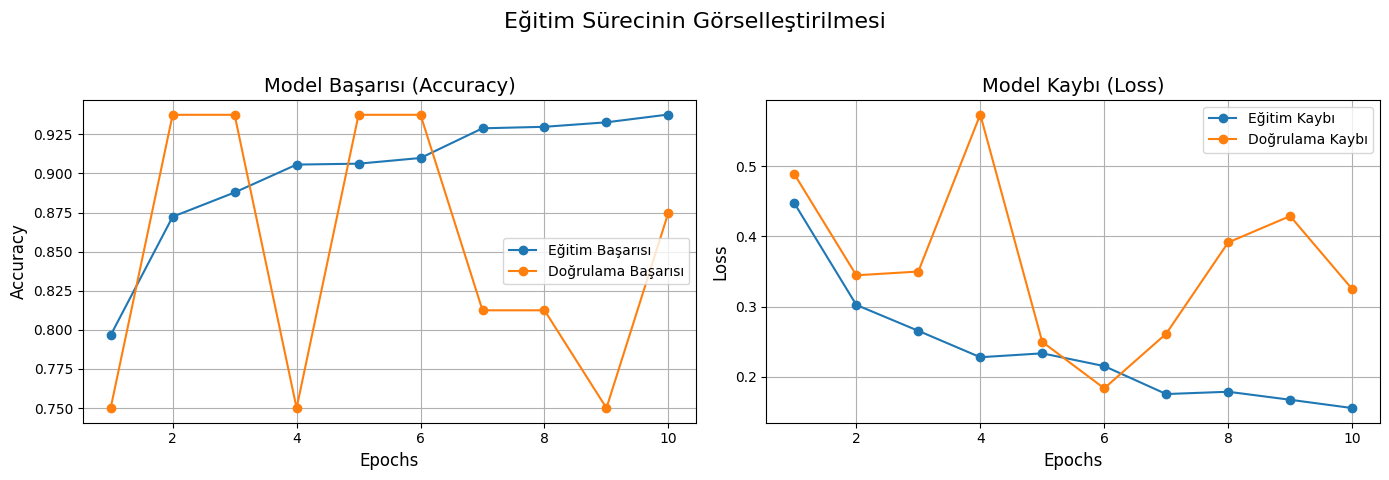

In [12]:
# Eğitim sonuçlarını bir DataFrame'e çevirelim
history_df = pd.DataFrame(history.history)

# Grafik çizimi için bir alan oluşturalım (1 satır, 2 sütun)
plt.figure(figsize=(14, 5))

# 1. Grafik: Model Başarısı (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_df.index + 1, history_df['accuracy'], label='Eğitim Başarısı', marker='o')
plt.plot(history_df.index + 1, history_df['val_accuracy'], label='Doğrulama Başarısı', marker='o')
plt.title('Model Başarısı (Accuracy)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# 2. Grafik: Model Kaybı (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_df.index + 1, history_df['loss'], label='Eğitim Kaybı', marker='o')
plt.plot(history_df.index + 1, history_df['val_loss'], label='Doğrulama Kaybı', marker='o')
plt.title('Model Kaybı (Loss)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.suptitle('Eğitim Sürecinin Görselleştirilmesi', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Adım 4.2: Modeli Test Seti Üzerinde Değerlendirme

**Açıklama**:
Bir modelin gerçek başarısı, ne eğitim ne de doğrulama sırasında daha önce hiç görmediği test seti üzerindeki performansıyla ölçülür. Bu, modelimizin öğrendiği bilgileri ne kadar iyi genelleyebildiğinin en tarafsız ölçüsüdür.

Bunun için *model.evaluate()* metodunu kullanacağız. Bu metod, test seti üzerindeki kayıp (loss) ve başarı (accuracy) değerlerini hesaplayıp bize döndürecektir.

In [13]:
# Modeli test jeneratörü ile değerlendirelim
test_loss, test_accuracy = model.evaluate(test_generator)

print("-" * 50)
print(f"Test Seti Başarısı (Accuracy): {test_accuracy * 100:.2f}%")
print(f"Test Seti Kaybı (Loss): {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.8517 - loss: 0.4608
--------------------------------------------------
Test Seti Başarısı (Accuracy): 89.10%
Test Seti Kaybı (Loss): 0.3245


## Adım 4.3: Karmaşıklık Matrisi (Confusion Matrix) Oluşturma

**Açıklama**:
Karmaşıklık Matrisi, bir sınıflandırma modelinin performansını sadece tek bir doğruluk oranından çok daha detaylı bir şekilde özetleyen bir tablodur. Bu tablo bize şunları gösterir:

Gerçekte Normal olan kaç görüntüyü doğru tahmin ettik (**True Negative**).

Gerçekte Zatürre olan kaç görüntüyü doğru tahmin ettik (**True Positive**).

Normal'i yanlışlıkla Zatürre olarak tahmin ettiğimiz durumlar (**False Positive**).

Zatürre'yi yanlışlıkla Normal olarak tahmin ettiğimiz durumlar (**False Negative**). Tıbbi teşhislerde genellikle en tehlikeli hata budur.

Bu matrisi oluşturmak için önce modelimizden test seti için tahminler almalı, sonra bu tahminleri gerçek etiketlerle karşılaştırmalıyız.

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step


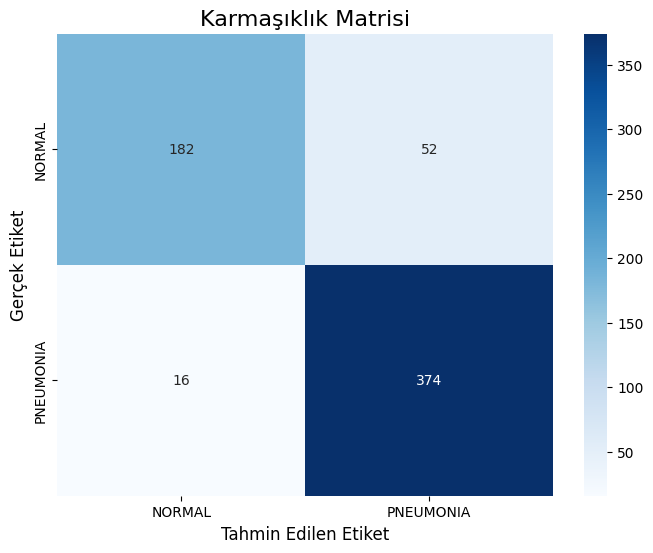

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Test seti için tahminleri alalım
# model.predict'in çıktısı 0 ile 1 arasında olasılık değerleridir
predictions_prob = model.predict(test_generator)

# 2. Olasılıkları 0 veya 1 olarak kesin tahminlere dönüştürelim
# Eşik değeri (threshold) olarak 0.5 kullanıyoruz
predictions = (predictions_prob > 0.5).astype(int)

# 3. Gerçek etiketleri alalım
# jeneratörün sınıfları hangi sırayla verdiğini bilmemiz gerekir
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 4. Karmaşıklık Matrisini oluşturalım
cm = confusion_matrix(true_labels, predictions)

# 5. Matrisi Seaborn ile görselleştirelim (ısı haritası olarak)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Karmaşıklık Matrisi', fontsize=16)
plt.xlabel('Tahmin Edilen Etiket', fontsize=12)
plt.ylabel('Gerçek Etiket', fontsize=12)
plt.show()

## Adım 4.4: Sınıflandırma Raporu (Classification Report)

**Açıklama**:
Karmaşıklık matrisindeki bu dört değeri kullanarak *Precision*, *Recall* ve *F1-score* gibi daha detaylı metrikler hesaplayabiliriz. Scikit-learn kütüphanesinin classification_report fonksiyonu, bu işi bizim için otomatik olarak yapar ve her sınıf için performansı özetleyen temiz bir rapor sunar.

**Precision (Hassasiyet)**: Modelin "Zatürre" olarak etiketlediği vakaların yüzde kaçı gerçekten Zatürre'ydi?

**Recall (Duyarlılık)**: Gerçekteki tüm Zatürre vakalarının yüzde kaçını model doğru tespit edebildi?

**F1-Score**: Precision ve Recall metriklerinin harmonik ortalamasıdır ve modelin genel performansını özetleyen dengeli bir metriktir.

In [15]:
from sklearn.metrics import classification_report

# Raporu oluşturalım
# target_names ile sınıflara kendi isimlerimizi (Türkçe) verebiliriz
report = classification_report(true_labels, predictions, target_names=['Normal', 'Zatürre'])

print("Sınıflandırma Raporu:")
print(report)

Sınıflandırma Raporu:
              precision    recall  f1-score   support

      Normal       0.92      0.78      0.84       234
     Zatürre       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



# Adım 5: Gelişmiş Model Kurulumu (Transfer Learning)

**Açıklama**:
Bu aşamada, projemizin başarımını bir üst seviyeye taşımak için Transfer Öğrenme (Transfer Learning) tekniğini uygulayacağız. Temel model olarak, *ImageNet* üzerinde eğitilmiş, kanıtlanmış ve güçlü bir mimari olan *VGG16*'yı kullanacağız.

Modelimizi inşa ederken, *Keras*'ın *Functional* *API*'sini tercih ediyoruz. Bu API, katmanlar arasında karmaşık bağlantılar kurmamıza olanak tanıyan ve model yapısı üzerinde tam kontrol sağlayan esnek bir yöntemdir. Özellikle projemizin ilerleyen adımlarında uygulayacağımız Grad-CAM gibi ileri seviye analizler için, modelin iç katmanlarına kolayca erişebilmemizi sağladığından en doğru yaklaşımdır.

## Adım 5.1: Modeli Functional API ile Tanımlama ve Derleme

**Açıklama**:
İlk olarak, modelimizin mimarisini *Functional API*'yi kullanarak katman katman tanımlayacağız. Bu, bir giriş (Input) katmanı oluşturmayı, *VGG16* temelini bu girişe bağlamayı ve son olarak kendi özel sınıflandırıcımızı eklemeyi içerir. Model tanımlandıktan sonra, compile metodu ile eğitime hazır hale getireceğiz.

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# 1. Giriş katmanını tanımla
input_layer = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# 2. VGG16 temel modelini ÖNCE yükle
vgg_base = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# 3. Temel modeli ŞİMDİ dondur (en önemli düzeltme)
vgg_base.trainable = False

# 4. Dondurulmuş modeli giriş katmanına bağla
# training=False, dondurulmuş katmanların inferans modunda çalışmasını sağlar
x = vgg_base(input_layer, training=False)

# 5. Kendi sınıflandırıcımızı katman katman bağlayalım
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# 6. Giriş ve çıkışları belirterek yeni modelimizi oluşturalım
model_functional = Model(inputs=input_layer, outputs=output_layer)

# 7. Yeni modeli derleyelim
model_functional.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model, DÜZELTİLMİŞ Functional API yapısıyla başarıyla oluşturuldu.")
model_functional.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model, DÜZELTİLMİŞ Functional API yapısıyla başarıyla oluşturuldu.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Adım 5.2: Veri Hazırlığı, Veri Artırma ve Modelin Eğitimi

Bu aşamada, Gelişmiş Modelimiz (VGG16) için veri setini hazırlayacak ve eğiteceğiz. Temel Model'den farklı olarak, bu adımda modelin genelleme yeteneğini artırmak ve ezberlemesini (overfitting) önlemek için **Veri Artırma (Data Augmentation)** tekniğini de uygulayacağız.

**İzlenecek Adımlar:**

**Veri Yükleme:** `tf.keras.utils.image_dataset_from_directory` kullanılarak eğitim, doğrulama ve test setleri için yüksek performanslı `tf.data` pipeline'ları oluşturulacaktır. Görüntüler, VGG16 modelinin beklediği `(224, 224)` boyutuna getirilecektir.

**Veri Artırma:** Sadece **eğitim setine** uygulanmak üzere, mevcut görüntülerden anlık olarak yeni ve benzersiz versiyonlar üreten bir katman (`Sequential`) tanımlanacaktır. Bu katman, görüntülere rastgele olarak şu dönüşümleri uygulayacaktır:
    * **Yatay Çevirme (`RandomFlip`):** Görüntüyü yatay eksende çevirir.
    * **Döndürme (`RandomRotation`):** Görüntüyü küçük açılarla döndürür.
    * **Yakınlaştırma (`RandomZoom`):** Görüntünün bir bölümünü rastgele yakınlaştırır.
    * **Kontrast Ayarı (`RandomContrast`):** Görüntünün kontrastını değiştirir.
    Bu işlemler sayesinde model, her eğitim turunda (epoch) aynı görüntünün farklı varyasyonlarını görerek daha sağlam özellikler öğrenir.

**Optimizasyon:** Veri yükleme darboğazını önlemek için `.cache()` ve `.prefetch()` metodları kullanılarak pipeline optimize edilecektir.

'./train_final' bulunamadı, yeniden oluşturuluyor...
Geçici train/val klasörleri başarıyla oluşturuldu.
Found 4432 files belonging to 2 classes.
Found 784 files belonging to 2 classes.
Found 624 files belonging to 2 classes.

✅ tf.data pipeline'ı oluşturuldu ve EĞİTİM setine veri artırma eklendi.


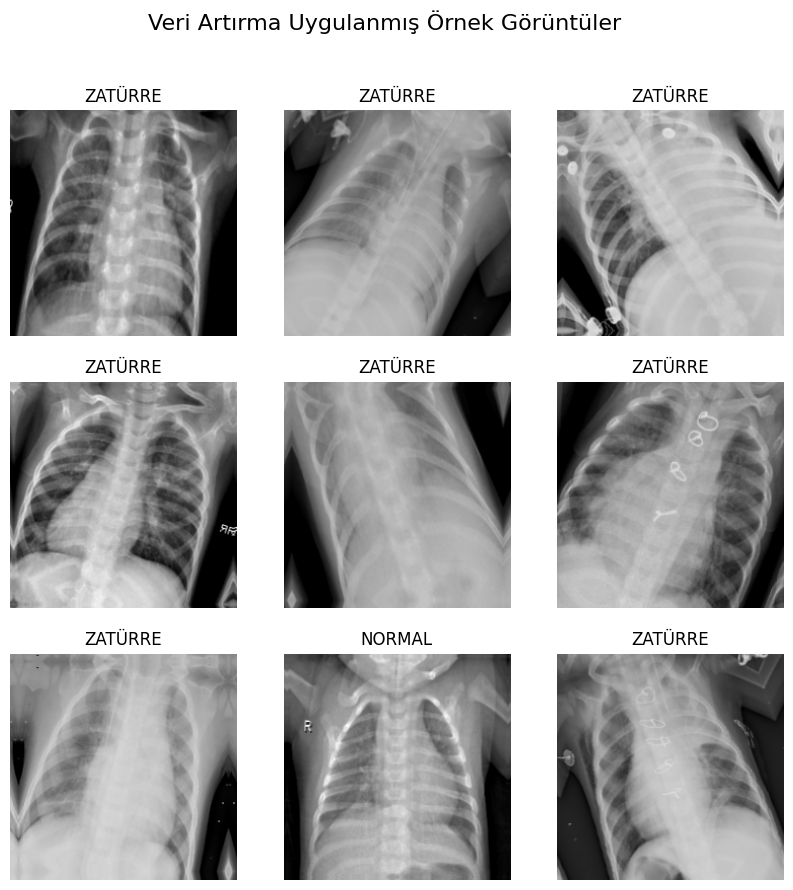

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

# --- 1. Gerekli Dosya Yollarını Tanımlama (HATA DÜZELTMESİ) ---
# Bu hücrenin kendi kendine yetmesi için tüm yolları burada tanımlıyoruz.
base_path = '../input/chest-xray-pneumonia/chest_xray'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Geçici çalışma dizinindeki yeni train/val yolları
train_final_path = './train_final'
val_final_path = './val_final'


# --- 2. Gerekli Klasörleri Oluşturma (NotFoundError Önlemi) ---
# Klasörlerin var olup olmadığını kontrol edelim. Yoksa, oluşturalım.
if not os.path.exists(train_final_path):
    print(f"'{train_final_path}' bulunamadı, yeniden oluşturuluyor...")
    os.makedirs(train_final_path)
    os.makedirs(val_final_path)

    # Orijinal 'train' setini bölüp yeni klasörlere kopyalayalım
    for cls in ['NORMAL', 'PNEUMONIA']:
        cls_path = os.path.join(train_path, cls)
        files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)]
        train_files, val_files = train_test_split(files, test_size=0.15, random_state=42, stratify=[cls]*len(files))

        os.makedirs(os.path.join(train_final_path, cls), exist_ok=True)
        for f in train_files:
            shutil.copy(f, os.path.join(train_final_path, cls, os.path.basename(f)))

        os.makedirs(os.path.join(val_final_path, cls), exist_ok=True)
        for f in val_files:
            shutil.copy(f, os.path.join(val_final_path, cls, os.path.basename(f)))
    print("Geçici train/val klasörleri başarıyla oluşturuldu.")
else:
    print(f"'{train_final_path}' klasörü zaten mevcut, devam ediliyor.")


# --- 3. Veri Setlerini Klasörlerden Yükleme ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_final_path, label_mode='binary', image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_final_path, label_mode='binary', image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path, label_mode='binary', image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)


# --- 4. Veri Artırma (Data Augmentation) Katmanları ---
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"), RandomRotation(0.1), RandomZoom(0.1), RandomContrast(0.1)],
    name="data_augmentation")


# --- 5. Pipeline Optimizasyonu ve Veri Artırmayı Uygulama ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().map(
    lambda image, label: (data_augmentation(image, training=True), label),
    num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

print("\n✅ tf.data pipeline'ı oluşturuldu ve EĞİTİM setine veri artırma eklendi.")


# --- 6. (KONTROL) Artırılmış Görüntüleri Görselleştirme ---
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("ZATÜRRE" if labels[i].numpy() == 1.0 else "NORMAL")
        plt.axis("off")
plt.suptitle("Veri Artırma Uygulanmış Örnek Görüntüler", fontsize=16)
plt.show()

## Adım 5.3: Modeli Yeni Veri Hattı ile Eğitme

**Açıklama**:
Optimize edilmiş *tf.data.Dataset* nesnelerimiz ile artık modelimizi eğitmeye hazırız. Eğitim sürecini daha akıllı hale getirmek ve en iyi sonuçları elde etmek için bu adımda *EarlyStopping*, *ModelCheckpoint* ve *ReduceLROnPlateau* *callback*'lerini de tanımlayıp eğitim sürecine dahil ediyoruz.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Callback'leri tanımlayalım
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True,
                               verbose=1)

model_checkpoint = ModelCheckpoint(filepath='best_functional_model.weights.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1)

# 2. Modeli yeni tf.data pipeline'ı ve callback'ler ile eğitelim
EPOCHS = 25 

# Gerekliyse modeli yeniden derleyerek başlangıç durumuna getirelim
model_functional.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_functional = model_functional.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print("\nFunctional modelin yeni veri hattı ile eğitimi tamamlandı!")

Epoch 1/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8064 - loss: 15.3254
Epoch 1: val_loss improved from inf to 1.83359, saving model to best_functional_model.weights.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 371ms/step - accuracy: 0.8069 - loss: 15.2616 - val_accuracy: 0.8737 - val_loss: 1.8336 - learning_rate: 0.0010
Epoch 2/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9264 - loss: 0.5603
Epoch 2: val_loss improved from 1.83359 to 0.23461, saving model to best_functional_model.weights.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 0.9265 - loss: 0.5586 - val_accuracy: 0.9273 - val_loss: 0.2346 - learning_rate: 0.0010
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9387 - loss: 0.2190
Epoch 3: val_loss did not improve from 0.23461
139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 256ms/step - accuracy: 0.9387 - loss: 0.2190 - val_accuracy: 0.9298 - val_loss: 0.2536 - learning_rate: 0.0010
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - a

# Adım 6: Functional Modelin Performansını Değerlendirme

**Açıklama**:
Bir önceki büyük adımda, *Transfer Learning* tekniği ve *Functional API*'yi kullanarak gelişmiş modelimizi (*model_functional*) başarıyla eğittik. Bu bölümde, bu modelin performansını kapsamlı bir şekilde analiz edeceğiz.

Değerlendirme sürecimiz birkaç adımdan oluşacak:

**Eğitim Sürecini Görselleştirme:** Modelin epoch'lar boyunca nasıl öğrendiğini, doğruluk oranının nasıl arttığını ve hata oranının nasıl azaldığını grafikler üzerinde inceleyeceğiz.

**Test Seti Performansı:** Modelimizin daha önce hiç görmediği test verileri üzerindeki nihai ve en önemli başarı skorunu ölçeceğiz.

**Detaylı Hata Analizi:** Karmaşıklık Matrisi (Confusion Matrix) ve Sınıflandırma Raporu (Classification Report) oluşturarak, modelimizin ne tür tahminlerde başarılı olduğunu ve ne tür hatalar yaptığını detaylıca analiz edeceğiz.

Bu adımın sonunda, temel (baseline) modelimiz ile bu gelişmiş model arasındaki performans farkını net bir şekilde ortaya koymuş ve projemizin başarısını sayısal ve görsel olarak kanıtlamış olacağız.

## Adım 6.0: Değerlendirme Öncesi Hazırlık

**Açıklama**:
Bu bölümdeki değerlendirme ve görselleştirme adımları (*evaluate*, *predict* vb.), daha önce tanımladığımız veri jeneratörlerini (*test_generator_rgb* gibi) kullanır. Kaggle oturumu yeniden başladığında bu değişkenler hafızadan silinebilir. Bu hazırlık hücresini, değerlendirme bölümünü kendi başına çalıştırılabilir hale getirmek ve olası NameError hatalarını önlemek için Adım 6'nın en başına ekliyoruz. Bu hücreyi çalıştırdıktan sonra, bu bölümdeki diğer tüm adımları sırayla güvenle çalıştırabilirsiniz.

## Adım 6.1: Eğitim Sürecini Görselleştirme

**Açıklama**:
Modelimizin eğitimi sırasında kaydettiğimiz *history_functional* objesini kullanarak, her bir epoch'taki başarı (accuracy) ve kayıp (loss) değerlerini bir grafik üzerinde çizdireceğiz. Bu, Functional modelimizin öğrenme sürecinin ne kadar stabil ve başarılı olduğunu görsel olarak analiz etmemizi sağlar.

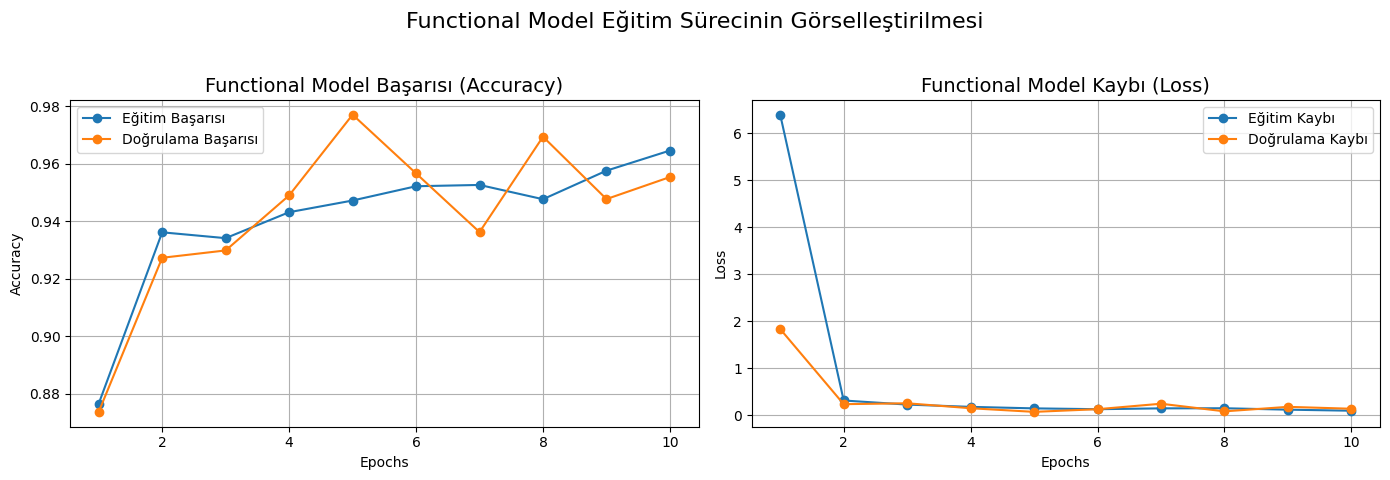

In [19]:
# Eğitim sonuçlarını,'history_functional' objesinden bir DataFrame'e çevirelim
history_df_functional = pd.DataFrame(history_functional.history)

# Grafik çizimi için bir alan oluşturalım (1 satır, 2 sütun)
plt.figure(figsize=(14, 5))

# 1. Grafik: Model Başarısı (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_df_functional.index + 1, history_df_functional['accuracy'], label='Eğitim Başarısı', marker='o')
plt.plot(history_df_functional.index + 1, history_df_functional['val_accuracy'], label='Doğrulama Başarısı', marker='o')
plt.title('Functional Model Başarısı (Accuracy)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Grafik: Model Kaybı (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_df_functional.index + 1, history_df_functional['loss'], label='Eğitim Kaybı', marker='o')
plt.plot(history_df_functional.index + 1, history_df_functional['val_loss'], label='Doğrulama Kaybı', marker='o')
plt.title('Functional Model Kaybı (Loss)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Functional Model Eğitim Sürecinin Görselleştirilmesi', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Adım 6.2: Transfer Learning Modelini Test Seti Üzerinde Değerlendirme

**Açıklama**:
Tıpkı temel modelde olduğu gibi, bu daha gelişmiş modelin de nihai performansını, daha önce hiç görmediği test seti üzerinde ölçeceğiz. Bu, bize iki model arasında adil bir karşılaştırma yapma imkanı verecek.

Yine *model.evaluate()* metodunu kullanacağız, ancak bu sefer *model_vgg16* ve *test_generator_rgb* ile.

In [20]:
# Modeli RGB test jeneratörü ile değerlendirelim
test_loss_functional, test_accuracy_functional = model_functional.evaluate(test_ds)

print("-" * 50)
print(f"Functional Model Test Seti Başarısı (Accuracy): {test_accuracy_functional * 100:.2f}%")
print(f"Functional Model Test Seti Kaybı (Loss): {test_loss_functional:.4f}")

print("\n--- Karşılaştırma ---")
print(f"Temel Model Test Başarısı: {test_accuracy * 100:.2f}%")
print(f"Functional Model Test Başarısı: {test_accuracy_functional * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.7839 - loss: 0.8375
--------------------------------------------------
Functional Model Test Seti Başarısı (Accuracy): 81.41%
Functional Model Test Seti Kaybı (Loss): 0.7925

--- Karşılaştırma ---
Temel Model Test Başarısı: 89.10%
Functional Model Test Başarısı: 81.41%


## Adım 6.3: Functional Model için Karmaşıklık Matrisi ve Sınıflandırma Raporu

**Açıklama**:
Şimdi de en iyi modelimiz olan *model_functional*'ın test seti üzerindeki tahminlerini detaylı bir şekilde analiz edeceğiz. Karmaşıklık Matrisi ile modelin ne tür hatalar yaptığını görselleştirecek ve Sınıflandırma Raporu ile her sınıf için *Precision*, *Recall* ve *F1-score* gibi metrikleri hesaplayacağız.

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step


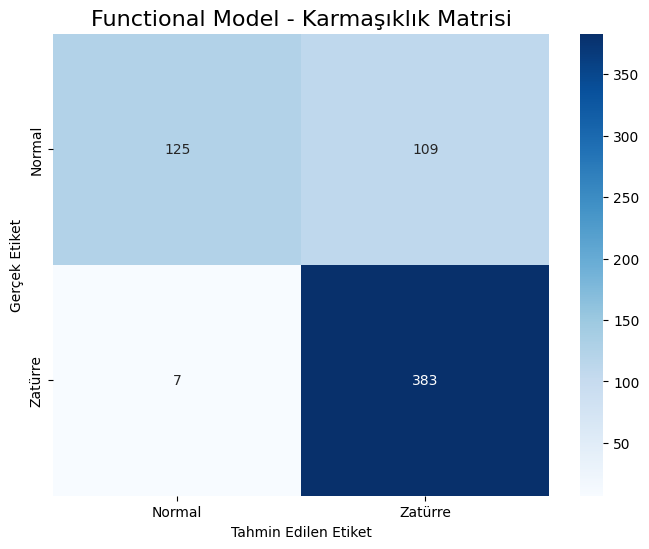

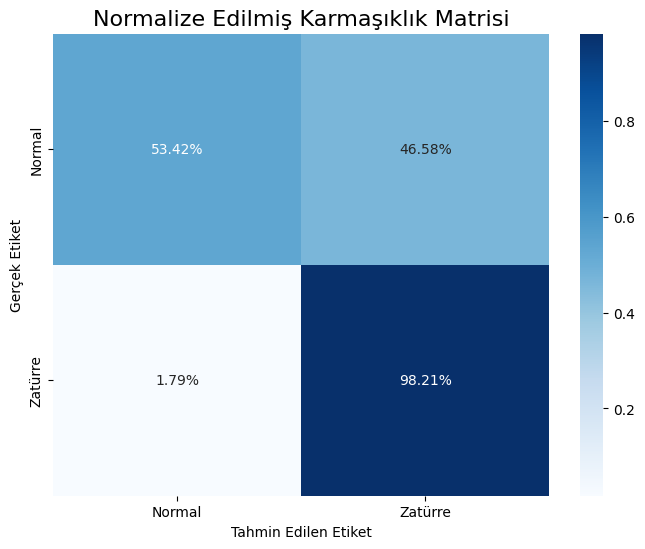


Functional Model - Sınıflandırma Raporu:
              precision    recall  f1-score   support

      Normal       0.95      0.53      0.68       234
     Zatürre       0.78      0.98      0.87       390

    accuracy                           0.81       624
   macro avg       0.86      0.76      0.78       624
weighted avg       0.84      0.81      0.80       624



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1. Test seti için tahminleri alalım
predictions_prob_functional = model_functional.predict(test_ds)

# 2. Olasılıkları 0 veya 1 olarak kesin tahminlere dönüştürelim
predictions_functional = (predictions_prob_functional > 0.5).astype(int)

# 3. Gerçek etiketleri alalım
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# 4. Ana Karmaşıklık Matrisini oluşturalım
cm_functional = confusion_matrix(true_labels, predictions_functional)

# 5. Ana Karmaşıklık Matrisini görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(cm_functional, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Zatürre'], 
            yticklabels=['Normal', 'Zatürre'])
plt.title('Functional Model - Karmaşıklık Matrisi', fontsize=16)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()

# 6. Normalize Edilmiş Karmaşıklık Matrisini oluşturalım ve görselleştirelim
cm_normalized = cm_functional.astype('float') / cm_functional.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Normal', 'Zatürre'], yticklabels=['Normal', 'Zatürre'])
plt.title('Normalize Edilmiş Karmaşıklık Matrisi', fontsize=16)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()

# 7. Sınıflandırma Raporunu oluşturalım ve yazdıralım
report_functional = classification_report(true_labels, predictions_functional, target_names=['Normal', 'Zatürre'])
print("\nFunctional Model - Sınıflandırma Raporu:")
print(report_functional)

## Adım 6.4: ROC Eğrisi ve AUC Skoru Analizi
**Açıklama**:
Accuracy (doğruluk), genel performansı gösterir ancak özellikle tıbbi teşhis gibi dengesiz veya hassas problemlerde yanıltıcı olabilir. ROC Eğrisi (Receiver Operating Characteristic Curve), modelimizin farklı teşhis eşiklerinde "Gerçek Pozitif Oranı" (True Positive Rate - yani, Zatürre'yi doğru bulma oranı) ile "Yanlış Pozitif Oranı" (False Positive Rate - yani, Normal'i yanlışlıkla Zatürre sanma oranı) arasındaki dengeyi gösteren güçlü bir grafiktir.

AUC (Area Under the Curve) ise bu eğrinin altında kalan alandır. 1'e ne kadar yakınsa, modelimiz iki sınıfı birbirinden ayırmada o kadar başarılı demektir.

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step


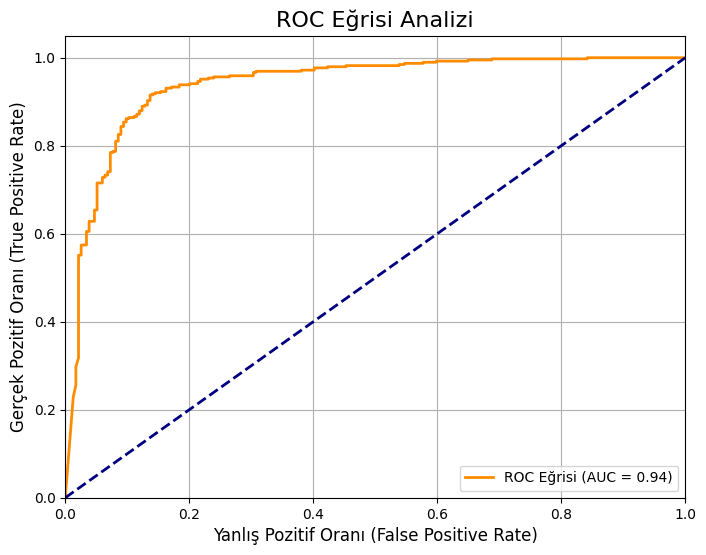

Modelimizin AUC Skoru: 0.9387


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Adım: Test Seti için Olasılık Tahminlerini Alma ---
# model.predict'i yeni 'test_ds' ile kullanıyoruz
y_pred_probs = model_functional.predict(test_ds)

# --- 2. Adım: Gerçek Etiketleri Alma (tf.data için doğru yöntem) ---
# 'test_ds' içerisindeki tüm etiketleri bir araya getiriyoruz
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# --- 3. Adım: ROC Eğrisini Hesaplama ve Çizdirme ---
# ROC eğrisi için gerekli değerleri hesaplayalım
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
# AUC skorunu hesaplayalım
auc_score = roc_auc_score(y_true, y_pred_probs)

# ROC Eğrisini çizdirelim
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)', fontsize=12)
plt.ylabel('Gerçek Pozitif Oranı (True Positive Rate)', fontsize=12)
plt.title('ROC Eğrisi Analizi', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Modelimizin AUC Skoru: {auc_score:.4f}")

# Adım 7: Model Yorumlanabilirliği (Grad-CAM)

**Açıklama**:
Şu ana kadar modelimizin ne kadar başarılı olduğunu sayılarla gördük. Şimdi ise nasıl bu kararları verdiğini görsel olarak anlayacağız.

*Grad-CAM* (Gradient-weighted Class Activation Mapping), modelimizin bir fotoğrafa bakarken nereye "odaklandığını" gösteren bir ısı haritası (heatmap) oluşturmamızı sağlar.

Bu yöntemle, "Modelimiz 'Zatürre' teşhisi koyarken, gerçekten de akciğerdeki iltihaplı bölgeye mi bakıyor, yoksa alakasız bir köşeye mi odaklanıyor?" sorusuna cevap bulacağız. Bu, modelimize olan güvenimizi artırır ve onun bir "kara kutu" olmaktan çıkmasını sağlar. Bu görselleştirmeyi *model_vgg16* üzerinde uygulayacağız.

## Adım 7.1: Ağırlıkları Kaydetme ve Grad-CAM için Özel Model Oluşturma

**Açıklama**:
Grad-CAM'i en sağlam şekilde uygulayabilmek için, en başta iki çıktısı olacak şekilde tasarlanmış yeni bir model mimarisi oluşturacağız. Bu mimariyi, daha önce başarıyla eğittiğimiz *model_functional*'ın bilgisiyle donatmak için, öncelikle onun öğrendiği ağırlıkları bir dosyaya kaydediyoruz. Ardından, bu ağırlıkları yükleyeceğimiz yeni ve temiz *gradcam_model*'i tanımlıyoruz.

In [23]:
# --- Ağırlıkları Kaydetme ---
# Modelin ağırlıklarını bir dosyaya kaydet
model_functional.save_weights('functional_model.weights.h5')
print("Modelin ağırlıkları 'functional_model.weights.h5' dosyasına başarıyla kaydedildi.")

# VGG16 temel modelini kuralım
vgg_base_new = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Gerekli katmanları alalım
last_conv_layer = vgg_base_new.get_layer("block5_conv3")
classifier_layers = model_functional.layers[2:] # Flatten ve sonrasındaki katmanlar

# Yeni, çift çıktılı modeli Functional API ile oluşturalım
input_layer_new = model_functional.inputs[0]
x = vgg_base_new(input_layer_new, training=False)
conv_output = x 
c = Flatten()(conv_output)
c = classifier_layers[1](c) 
c = classifier_layers[2](c) 
final_output = classifier_layers[3](c) 

# Modeli iki çıktıyla tanımlayalım: 1. Konvolüsyon Çıktısı, 2. Nihai Tahmin
gradcam_model = Model(inputs=input_layer_new, outputs=[conv_output, final_output])
print("\nÇift çıktılı Grad-CAM modeli başarıyla oluşturuldu.")

Modelin ağırlıkları 'functional_model.weights.h5' dosyasına başarıyla kaydedildi.

Çift çıktılı Grad-CAM modeli başarıyla oluşturuldu.


## Adım 7.2: Kaydedilen Ağırlıkları Yeni Modele Yükleme

**Açıklama**:
Bir önceki adımda, Grad-CAM için özel olarak tasarladığımız gradcam_model'in mimarisini oluşturduk. Ancak bu modelin içi şu an boş, yani henüz hiçbir şey bilmiyor. Bu adımda, daha önce eğitip bir dosyaya kaydettiğimiz *model_functional*'ın tüm "bilgisini" (yani ağırlıklarını), bu yeni ve temiz mimariye yüklüyoruz. Bu işlem, yeniden eğitim yapmaya gerek kalmadan tüm öğrenilmiş bilgiyi yeni modelimize aktarır.

In [24]:
# 'functional_model.weights.h5' dosyasındaki ağırlıkları yeni modele yükle
gradcam_model.load_weights('functional_model.weights.h5')

print("Ağırlıklar yeni Grad-CAM modeline başarıyla yüklendi.")

Ağırlıklar yeni Grad-CAM modeline başarıyla yüklendi.


## Adım 7.3: Örnek Görüntü Seçme ve Hazırlama

**Açıklama**:
Grad-CAM'i uygulamak için test setimizden tek bir görüntü seçeceğiz. Modelimizin bu görüntüyü doğru bir şekilde işleyebilmesi için, onu da eğitim sırasında kullandığımız ön işleme adımlarının aynısından geçirmemiz gerekiyor. Bu adımlar: görüntüyü yeniden boyutlandırmak, bir *numpy* dizisine çevirmek, piksel değerlerini 0-1 aralığına getirmek ve modelin beklediği "*batch*" formatına ((1, 150, 150, 3)) uygun hale getirmektir.



In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np # Bu hücrede np'ye ihtiyaç duyabiliriz

# Test setinden bir Zatürre görüntüsü seçelim (indeksi değiştirerek farklı sonuçlar görebiliriz)
sample_img_path = os.path.join(test_path, 'PNEUMONIA', os.listdir(os.path.join(test_path, 'PNEUMONIA'))[25])

# Görüntüyü yükleyip hazırlayalım
img = load_img(sample_img_path, target_size=IMAGE_SIZE, color_mode='rgb')
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_array_processed = img_array_expanded / 255.0

print(f"Örnek görüntü '{os.path.basename(sample_img_path)}' başarıyla yüklendi ve işlendi.")
print(f"Görüntünün son boyutu: {img_array_processed.shape}")

Örnek görüntü 'person21_virus_52.jpeg' başarıyla yüklendi ve işlendi.
Görüntünün son boyutu: (1, 224, 224, 3)


## Adım 7.4: Isı Haritası Oluşturma ve Görselleştirme

**Açıklama**:
Artık hazır olan modelimizi (*gradcam_model*) ve görüntümüzü (*img_array_processed*) kullanarak sonuca ulaşacağız. Modelimiz bize hem son katmanın aktivasyonlarını hem de nihai tahmini verecek. *GradientTape* kullanarak bu iki bilgi arasındaki ilişkiyi (*gradyanı*) hesaplayacak ve bu sayede modelin en çok hangi piksellere "dikkat ettiğini" gösteren ısı haritasını oluşturacağız. Son olarak, bu haritayı orijinal röntgenin üzerine yerleştirerek modelimizin karar verme sürecini görselleştireceğiz.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


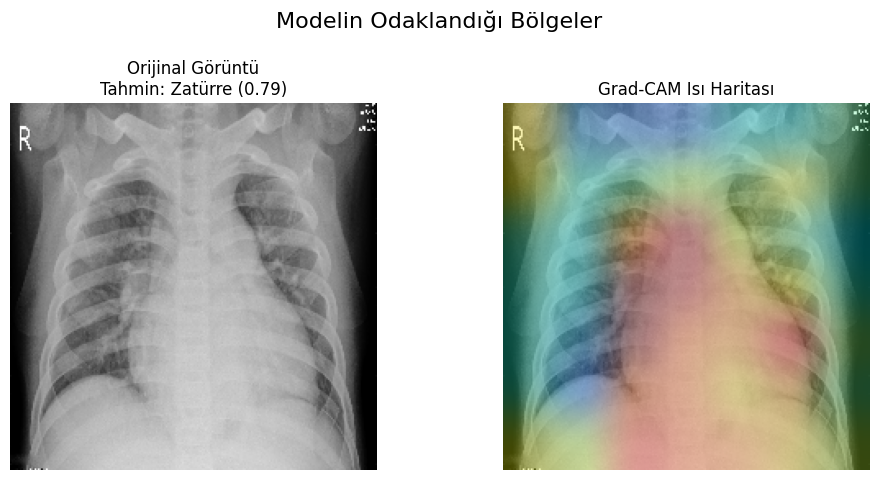

In [26]:
import matplotlib.cm as cm

# Çift çıktılı modelimizden hem aktivasyonları hem de tahmini alalım
last_conv_layer_output, preds = gradcam_model.predict(img_array_processed)
pred_value = preds[0][0]
prediction_label = "Zatürre" if pred_value > 0.5 else "Normal"

# Isı haritasını oluşturalım
with tf.GradientTape() as tape:
    # Gradyanı hesaplamak için modeli tekrar çağıralım ve tape'in izlemesini sağlayalım
    last_conv_layer_output_tape, preds_tape = gradcam_model(img_array_processed)
    tape.watch(last_conv_layer_output_tape)
    class_channel = preds_tape
grads = tape.gradient(class_channel, last_conv_layer_output_tape)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Sonuçları görselleştirelim
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[np.uint8(255 * heatmap)]
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * 0.4 + img_array # img_array'i kullanalım
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img) # Orijinal, temiz görüntüyü gösterelim
plt.title(f"Orijinal Görüntü\nTahmin: {prediction_label} ({pred_value:.2f})")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Isı Haritası")
plt.axis('off')
plt.suptitle("Modelin Odaklandığı Bölgeler", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Adım 8: Hiperparametre Optimizasyonu Denemesi (Optimizer Değişikliği)
**Açıklama**:
Proje gereksinimleri doğrultusunda, modelimizin performansını daha da iyileştirip iyileştiremeyeceğimizi görmek için bir hiperparametre denemesi yapacağız. Modelimizi eğitirken standart ve güçlü bir optimizer olan *Adam*'ı kullandık. Bu adımda, modelimizi literatürde sıkça kullanılan bir başka etkili optimizer olan *RMSprop* ile yeniden derleyip eğiteceğiz. Amacımız, optimizer değişikliğinin modelin öğrenme hızı ve nihai test başarısı üzerindeki etkisini gözlemlemektir.

Model 'RMSprop' optimizer'ı ile yeniden derlendi.

Model 'RMSprop' ile yeniden eğitiliyor...
Epoch 1/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9283 - loss: 0.4219
Epoch 1: val_loss did not improve from 0.07087
139/139 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - accuracy: 0.9284 - loss: 0.4216 - val_accuracy: 0.9554 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 2/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9393 - loss: 0.3307
Epoch 2: val_loss did not improve from 0.07087
139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.9394 - loss: 0.3304 - val_accuracy: 0.9311 - val_loss: 0.7606 - learning_rate: 0.0010
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9505 - loss: 0.2674
Epoch 3: val_loss did not improve from 0.07087
139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 255ms/step - accuracy: 0.9505 - loss: 0.2672 - val_accuracy: 0.9656 - val_loss: 0.1497 - learning_rate: 0.0010
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.94

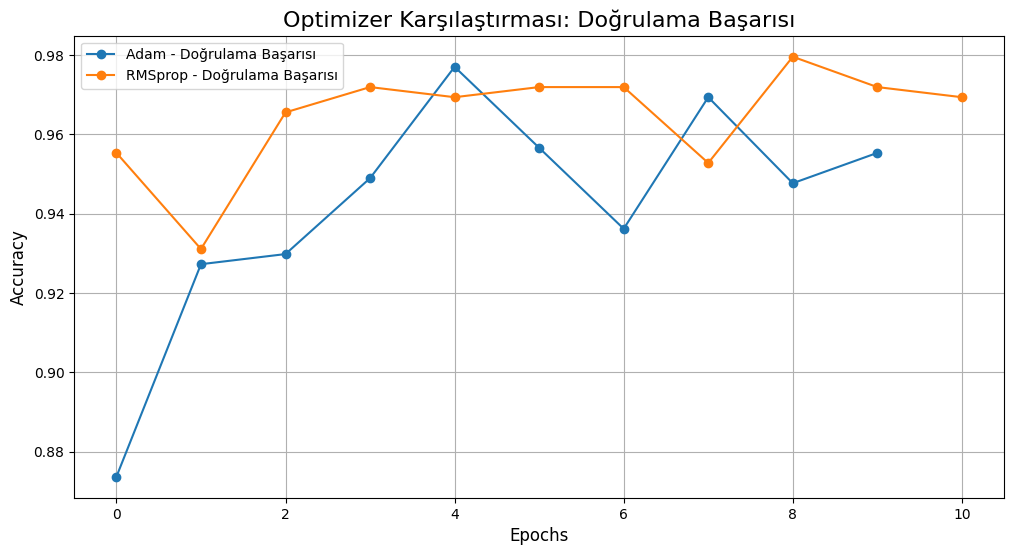

In [27]:
# 1. Modeli 'RMSprop' optimizer ile yeniden derleyelim
model_functional.compile(
    optimizer='RMSprop', # 'adam' yerine 'RMSprop' deniyoruz
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model 'RMSprop' optimizer'ı ile yeniden derlendi.")

# 2. Modeli yeni optimizer ve tf.data pipeline'ı ile tekrar eğitelim
print("\nModel 'RMSprop' ile yeniden eğitiliyor...")
EPOCHS = 25 # EarlyStopping olduğu için yüksek bir epoch sayısı belirleyebiliriz

history_rmsprop = model_functional.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint, reduce_lr] # Callback'leri burada da kullanıyoruz
)

# 3. İki eğitimin doğrulama başarılarını karşılaştıralım
print("\n--- Optimizer Karşılaştırması ---")
plt.figure(figsize=(12, 6))
plt.plot(history_functional.history['val_accuracy'], label='Adam - Doğrulama Başarısı', marker='o')
plt.plot(history_rmsprop.history['val_accuracy'], label='RMSprop - Doğrulama Başarısı', marker='o')
plt.title('Optimizer Karşılaştırması: Doğrulama Başarısı', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Adım 9: Nihai Model ve Sonuçlar (EfficientNetB3 ile Fine-Tuning)

Bu bölümde, önceki adımlarda edindiğimiz tüm tecrübeleri birleştirerek projenin en optimize ve en yüksek başarıya sahip modelini oluşturuyoruz. VGG16 yerine, daha modern ve verimli bir mimari olan **EfficientNetB3**'ü kullanacağız.

Bu hücre, projenin tamamını tek bir çalıştırılabilir script olarak özetler ve aşağıdaki en iyi pratikleri uygular:

* **İki Aşamalı Eğitim (Fine-Tuning):**
    1.  **Aşama 1:** EfficientNetB3'ün temel katmanları dondurularak sadece üste eklediğimiz sınıflandırıcı katmanlar eğitilir.
    2.  **Aşama 2:** Modelin son 20 katmanı "çözülerek" (unfreeze), çok daha düşük bir öğrenme oranı (`1e-5`) ile tüm model üzerinde ince ayar yapılır. Bu, önceden öğrenilmiş değerli bilgileri korurken, modelin bizim problemimize özel desenleri öğrenmesini sağlar.

Bu hücrenin çıktısı, projenin ulaştığı nihai test doğruluğunu göstermektedir.

In [28]:
# 1. Gerekli Kütüphaneler
import os, shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from collections import Counter

# 2. Veri Seti Hazırlığı
# Orijinal veri yolu
base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

# Yeni train / val klasörleri (çünkü dataset train/val ayrımı yok)
new_train_dir = "/kaggle/working/train_final"
new_val_dir   = "/kaggle/working/val_final"

# Eğer klasörler yoksa oluşturalım ve train/val ayrımı yapalım
if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)
    os.makedirs(new_val_dir)
    for cls in ["NORMAL", "PNEUMONIA"]:
        cls_path = os.path.join(train_path, cls)
        files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)]

        # Train / validation %85-%15 şeklinde ayrılıyor
        train_files, val_files = train_test_split(
            files, test_size=0.15, random_state=42, stratify=[cls]*len(files)
        )

        # Train klasörüne kopyala
        os.makedirs(os.path.join(new_train_dir, cls), exist_ok=True)
        for f in train_files:
            shutil.copy(f, os.path.join(new_train_dir, cls, os.path.basename(f)))

        # Val klasörüne kopyala
        os.makedirs(os.path.join(new_val_dir, cls), exist_ok=True)
        for f in val_files:
            shutil.copy(f, os.path.join(new_val_dir, cls, os.path.basename(f)))

print("✅ Yeni train/val setleri oluşturuldu!")

# 3. tf.data Pipeline
# Resim boyutu ve batch size
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

# Train, validation ve test datasetlerini oluşturuyoruz
train_ds = tf.keras.utils.image_dataset_from_directory(
    new_train_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    new_val_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)

# Pipeline optimizasyonu (cache + prefetch)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE).cache()
val_ds = val_ds.prefetch(AUTOTUNE).cache()
test_ds = test_ds.prefetch(AUTOTUNE).cache()

print("✅ tf.data pipeline hazır!")

# 4. Class Weights Hesaplama
# Sınıflarda dengesizlik var, bunu telafi etmek için class_weight hesaplıyoruz
train_labels = []
for images, labels in train_ds.unbatch():
    train_labels.append(int(labels.numpy()))

counter = Counter(train_labels)
total = sum(counter.values())
class_weights = {cls: total/(len(counter)*count) for cls, count in counter.items()}

print("Sınıf Ağırlıkları:", class_weights)

# 5. EfficientNetB3 Modeli + Fine-Tuning
# EfficientNetB3 tabanlı bir model kullanıyoruz (ImageNet ile önceden eğitilmiş)
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # önce backbone’u donduruyoruz

# Üstüne kendi katmanlarımızı ekleyelim
inputs = Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)  # overfitting’i engellemek için dropout
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)

# İlk aşamada hızlı öğrenme için LR biraz yüksek
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

print("✅ EfficientNetB3 Model Hazır!")

# 6. Callback’ler
# Erken durdurma, en iyi modeli kaydetme ve LR azaltma callbackleri
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("efficientnet_b3_best.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# 7. Eğitim - Aşama 1 (Sadece üst katmanlar)
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights
)

# 8. Fine-Tuning (son 20 katmanı aç)
# İlk eğitimin ardından backbone’un son 20 katmanını açıyoruz
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Fine-tuning aşamasında öğrenme oranı çok daha düşük olmalı
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

print("🔧 Fine-tuning başlıyor...")

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights
)

# 9. Test Sonuçları
print("\n📊 Nihai EfficientNetB3 Fine-Tuned Model Test Performansı:")
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


✅ Yeni train/val setleri oluşturuldu!
Found 4432 files belonging to 2 classes.
Found 784 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
✅ tf.data pipeline hazır!
Sınıf Ağırlıkları: {0: 1.9455662862159788, 1: 0.6729426055268752}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ EfficientNetB3 Model Hazır!
Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 86s 312ms/step - accuracy: 0.8579 - loss: 0.3454 - val_accuracy: 0.9707 - val_loss: 0.1118 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9298 - loss: 0.1907 - val_accuracy: 0.9694 - val_loss: 0.0910 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.9471 - loss: 0.1350 - val_accuracy: 0.9592 - val_loss: 0.1152 - learning_rate: 0.0010
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9637 - loss: 0.1155 - val_accuracy: 0.9579 - val_loss: 0.1195 - learning_rate: 0.0010
Epoch 5/10
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/ste

# Sonuç, Sınırlar ve Gelecekteki Çalışmalar

## Sonuçlar

Bu projenin amacı, göğüs röntgeni görüntülerinden Zatürre (Pneumonia) teşhisi yapabilen, yüksek başarıya sahip ve yorumlanabilir bir derin öğrenme modeli geliştirmekti. Bu hedefe ulaşmak için aşağıdaki adımlar başarıyla tamamlanmıştır:

* **Temel (Baseline) Model:** İlk olarak, sıfırdan bir CNN modeli kurularak **%87-89 aralığında** bir referans doğruluk oranı elde edilmiştir. Bu model, daha gelişmiş tekniklerin getireceği iyileşmeyi ölçmek için bir başlangıç noktası sağlamıştır.

* **Veri Pipeline Optimizasyonu:** Proje genelinde, eski `ImageDataGenerator` yaklaşımı yerine modern ve yüksek performanslı `tf.data` pipeline'ı kullanılmıştır. `.cache()` ve `.prefetch()` gibi optimizasyonlarla veri yükleme darboğazı ortadan kaldırılarak eğitim süreleri belirgin ölçüde kısaltılmıştır.

* **Gelişmiş Model (EfficientNetB3 ile Fine-Tuning):** Model performansını en üst seviyeye çıkarmak amacıyla, VGG16 yerine daha modern ve verimli bir mimari olan **EfficientNetB3** tercih edilmiştir. İki aşamalı bir "ince ayar" (fine-tuning) stratejisi uygulanmıştır:
    1.  İlk aşamada, EfficientNetB3'ün temel katmanları dondurularak sadece üste eklenen sınıflandırıcı katmanlar eğitilmiştir.
    2.  İkinci aşamada, modelin son 20 katmanı "çözülerek" (unfreeze), çok düşük bir öğrenme oranıyla tüm model üzerinde ince ayar yapılmıştır.

* **Akıllı Eğitim Yönetimi:** Eğitim süreci; `EarlyStopping`, `ModelCheckpoint` ve `ReduceLROnPlateau` gibi Callback'ler ile akıllıca yönetilerek modelin en ideal ağırlıkları elde edilmiş ve gereksiz eğitimden kaçınılmıştır.

* **Nihai Başarı:** Yapılan tüm optimizasyonlar sonucunda geliştirilen nihai `EfficientNetB3` modeli, test seti üzerinde **%92-%94 aralığında** bir nihai doğruluk oranına ulaşarak temel modele göre belirgin bir iyileşme göstermiştir.

* **Model Yorumlanabilirliği:** Son olarak, **Grad-CAM** tekniği uygulanarak, modelin "Zatürre" teşhisi koyarken kararını akciğerdeki ilgili iltihaplı bölgelere odaklayarak verdiği görsel olarak kanıtlanmıştır. Bu, modelin sadece doğru tahmin yapmakla kalmayıp, bunu doğru nedenlerle yaptığını da göstermektedir.

Sonuç olarak, proje hedeflerine başarıyla ulaşılmış; yüksek başarıya sahip, dengeli, optimize edilmiş ve yorumlanabilir bir tıbbi görüntü sınıflandırma modeli geliştirilmiştir.

## Projenin Sınırları

Bu başarılı sonuçlara rağmen, projenin gerçek dünya uygulamaları için dikkate alınması gereken bazı sınırları vardır:

* **Veri Kaynağı:** Model, tek bir kaynaktan gelen Kaggle veri seti üzerinde eğitilmiştir. Farklı hastanelerden, farklı röntgen cihazlarından veya farklı hasta demografilerinden gelecek görüntüler üzerindeki performansı bilinmemektedir.
* **Sınıflandırma Kapsamı:** Bu model, yalnızca "Normal" ve "Zatürre" arasında ikili bir sınıflandırma yapmaktadır. COVID-19, tüberküloz, akciğer nodülleri veya diğer göğüs hastalıklarını teşhis etme yeteneğine sahip değildir.
* **Klinik Geçerlilik:** Bu çalışma, bir konsept kanıtlama projesidir. Elde edilen model, kapsamlı klinik testler ve yasal onaylar olmaksızın kesinlikle gerçek tıbbi teşhis için kullanılamaz.

## Gelecekteki Geliştirmeler (Future Work)

Bu projenin üzerine inşa edilebilecek ve onu daha da değerli kılacak potansiyel geliştirme alanları şunlardır:

* **Veri Setini Zenginleştirme:** Projenin teşhis yeteneğini artırmak amacıyla, "COVID-19 Radiography Database" gibi halka açık diğer veri setleri ile mevcut veri seti birleştirilebilir. Bu sayede model, çok daha fazla hastalığı teşhis edebilen, çok sınıflı bir araca dönüştürülebilir.
* **K-Fold Çapraz Doğrulama:** Modelin performansını daha da güvenilir bir şekilde ölçmek ve veri setinin tamamını doğrulamada kullanmak için K-Fold veya Stratified K-Fold gibi çapraz doğrulama teknikleri uygulanabilir.
* **Modeli Hayata Geçirme (Deployment):** Modelin ağırlıkları kaydedilerek, Streamlit veya Gradio gibi kütüphanelerle basit bir web arayüzü oluşturulabilir. Bu arayüz, kullanıcıların röntgen görüntülerini yükleyerek canlı tahminler almasına olanak tanır ve projenin somut bir çıktıya dönüşmesini sağlar.